In [4]:
from nltk.lm.vocabulary import Vocabulary
from nltk import download
import glob
import itertools
import email
import string
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.data import load
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
download('punkt', download_dir='.')
download('stopwords')

### FUNCIONES
# Función para leer los emails de un directorio dado (num es el número de correos del directorio que se quieren leer)

def readEmails(url):
    url = str(url)
    mails = []
    i = 0
    for s in glob.glob(url+"*"):
        with open(url+s.split("\\")[1]) as file_:
            mail = email.message_from_file(file_)
            mails.append(mail.get("Subject"))
        
    return mails

# Función para leer un email dado una url
def read_email(url):
    subject = []
    with open(url) as file_:
            mail = email.message_from_file(file_)
            subject.append(mail.get("Subject"))
    return subject
def readEmailsWithBody(url):
    url = str(url)
    mails = []
    i = 0
    for s in glob.glob(url+"*"):
        with open(url+s.split("\\")[1], encoding='unicode_escape', errors='ignore') as file_:
            mail = email.message_from_file(file_)
            
            text = mail.get("Subject")
            if text is None:
                text=''
            for part in mail.walk():
                body = ''
                clean_body = ''
                
                if part.get_content_type() == "text/plain":
                    body = part.get_payload(decode=True)
                    body= body.decode('latin-1')
                    htmlParse = BeautifulSoup(body, 'html.parser')
                    if htmlParse.getText() is not None:
                        text=text+htmlParse.getText()
                elif part.get_content_type() == "text/html":
                    html_body = part.get_payload(decode=True)
                    body = html_body.decode('latin-1')
                    htmlParse = BeautifulSoup(body, 'html.parser')
                    if htmlParse.getText() is not None:
                        text=text+htmlParse.getText()
        if i>=100:
            break
        i+=1
        
        
                
        mails.append(text)
    return mails

# Función para leer un email dado una url
def read_email(url):
    subject = []
    with open(url) as file_:
            mail = email.message_from_file(file_)
            subject.append(mail.get("Subject"))
    return subject


[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Función para eliminar los signos de puntuación de un texto dado

def cleanText(text):
    punctuations = []
    words = ''
    if text != None:
        words = []
        for c in text:
            if c not in string.punctuation:

                punctuations.append(c)
        punctuations = ''.join(punctuations)

        for t in punctuations.split():
            if t.lower() not in stopwords.words('english'):

                words.append(t.lower())
        words = ' '.join(words)
    return words

In [6]:
spam_subjects = readEmails("Enron-Spam-Splited/train/no_deseado/") #9494
ham_subjects = readEmails("Enron-Spam-Splited/train/legítimo/")   #10828
#spam_subjects = readEmailsWithBody("Enron-Spam-Splited/train/no_deseado/") #9494
#ham_subjects = readEmailsWithBody("Enron-Spam-Splited/train/legítimo/")   #10828
clean_spam_subjects = [cleanText(s) for s in spam_subjects]
clean_ham_subjects = [cleanText(s) for s in ham_subjects]
clean_subjects = np.concatenate((clean_spam_subjects, clean_ham_subjects), axis=0)
print(clean_subjects)

['order cheap vallum ship worldwide' 'phamacy online dragnet' ''
 'meet 3 million eligible singles area'
 'dont know attract customers website' 'progress aujy dep'
 'search optimization'
 'yasheng group yhgg announces 1st quarter results 145 million revenue'
 'returned mail see transcript details' 'infected read details'
 'continued growth orbit drop inc acquisitions changes take place positioning obdp next level'
 'reporting' 'fw csfb independent power weeklyissue 44'
 'monthly deal report' 'loretta pricing' 'fw amendment im ii ppa'
 'weekly deal report' 'great news frontera' 'turbines' 'abb meeting'
 'weekend gas' 'brooklyn navy yard permitting issue']


Dividimos el conjunto de mensajes proporcionado en dos subconjuntos, uno de entrenamiento (con el 80% de los correos del conjunto incial) y el otro de validación (con el 20% de correos restantes), usando la bibioteca splitfolders de Python.

In [4]:
import splitfolders

splitfolders.ratio("Enron-Spam", output="Enron-Spam-Splited", seed=1337, ratio=(.8, .2))

Copying files: 25404 files [02:02, 207.70 files/s]


Para representar de forma numérica el contenido de los correos electrónicos usamos como modelo de lenguaje el conocido como bolsa de palabras
Bibliografía: https://scikit-learn.org/stable/modules/feature_extraction.html

In [279]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

Tokenizamos las palabras que encontramos en los correos y contamos las ocurrencias de cada una, y las representamos en una matriz en la que las filas se correponden con los distintos correos, mientras que las columnas son las distintas palabras que conforman el vocabulario.

In [291]:
x = vectorizer.fit_transform(clean_subjects)

Mostramos las 50 primeras palabras del vocabulario, que se correponden con las 50 primeras columnas de la matriz.

In [292]:
print(vectorizer.get_feature_names_out()[:50])

['00' '000000000053327' '004' '0071' '0074' '00754' '00971' '00nr' '01'
 '0100' '010101' '01082002' '01092002' '011238' '01140118' '011501'
 '011601' '01162002' '012201' '012901' '01405' '015607' '0179mfrp5640z13'
 '0199' '02' '0200' '02040208' '020501' '020629' '020901' '02110215'
 '021201' '021601' '02190222' '021931' '02232000' '022400' '02250301'
 '025' '025536' '0300' '0300hexane' '0301' '03040308' '030701' '0309'
 '03110315' '0313' '0314' '0315']


Mostramos las filas y columnas de la matriz en forma de array. Cada elemento representa el número de veces que aparece la palabra de la columna en el correo de la fila.

In [266]:
print(x.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Creamos un array, en el que los primeros elementos serán 1s, indicándole al clasificador que los correos correspondientes son considerados spam, y los últimos elementos serán 0s, que se corresponden con correos legítimos.

In [293]:
y = []
for i in range(9494):  #9494 correos de entrenamiento que son spam
    y.append(1)
for i in range(10828): #10828 correos del conjunto de entrenamiento 
    y.append(0)
y = np.array(y)

Entrenamos el clasificador de Naive Bayes Multinomial con el conjunto de entrenamiento y mostramos cómo clasificaría los 50 primeros correos del conjunto de entrenamiento (como son correos no deseados los debería clasificar como spam, es decir, con un 1).

In [295]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1)
clf.fit(x.toarray(), y)

print(clf.predict(x.toarray()[0:50]))

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


A continuación, leemos los correos del conjunto de validación y los limpiamos para eliminar símbolos de puntuación y "stopwords".

In [33]:
spam_subjects_val = readEmails("Enron-Spam-Splited/val/no_deseado/",2374)
ham_subjects_val = readEmails("Enron-Spam-Splited/val/legítimo/",2708)
clean_spam_subjects_val = [cleanText(s) for s in spam_subjects_val]
clean_ham_subjects_val = [cleanText(s) for s in ham_subjects_val]
clean_subjects_val = np.concatenate((clean_spam_subjects_val, clean_ham_subjects_val))
print(clean_subjects_val)

['sper pass anyone taking medications' '' 'server mailing' ...
 'fw fort pierce' 'lincoln electric'
 'proposed rule extends marketing affiliate regulations affiliates']


Tokenizamos las palabras encontradas en el conjunto de validación, y le pedimos al modelo que nos muestre la clasificación realizada de los 50 primeros correos (que deberían ser spam).

In [297]:
x_val = vectorizer.transform(clean_subjects_val).toarray()
print(clf.predict(x_val[:50]))

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1]


Sin embargo, como podemos comprobar, no todos los elementos son 1s, por lo que el modelo clasifica erróneamente algunos correos. Creamos una matriz de confusión para evaluar el desempeño del filtro, usando la librería seaborn para mostrarla.

Bibliografía: https://www.milindsoorya.com/blog/build-a-spam-classifier-in-python
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

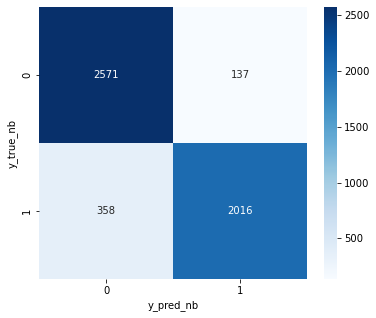

In [298]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_nb = clf.predict(x_val)     # Vector con la clasificación del filtro
y_true_nb = []                     # Vector con los resultados que debería dar el filtro
for i in range(2374):
    y_true_nb.append(1)
for i in range(2708):
    y_true_nb.append(0)
y_true_nb = np.array(y_true_nb)


cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(6,5))
sns.heatmap(cm,annot = True,fmt = ".0f",ax=ax,cmap="Blues")
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()

Por tanto, el filtro usando bolsa de palabras como modelo del lenguaje y naive Bayes Multinomial como modelo clasificador es el siguiente (se le debe proporcionar la url donde se encuentra el correo que se quiere clasificar)

In [14]:
def clasificador_nb(url):
    subject = read_email(url)
    clean_subject = [cleanText(s) for s in subject]
    print(subject)
    x = vectorizer.transform(clean_subject).toarray()
    res = clf.predict(x)
    if res[0] == 0:
        return False
    else:
        return True

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(clean_subjects)
print(vectors.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [152]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=1)

In [299]:
knc.fit(vectors, y)
print(knc.predict(vectors.toarray()[0:50]))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


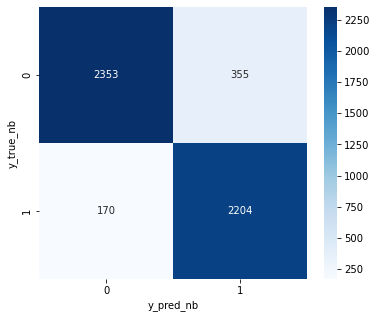

In [300]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_nb = knc.predict(x_val)     # Vector con la clasificación del filtro
y_true_nb = []                     # Vector con los resultados que debería dar el filtro
for i in range(2374):
    y_true_nb.append(1)
for i in range(2708):
    y_true_nb.append(0)
y_true_nb = np.array(y_true_nb)


cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(6,5))
sns.heatmap(cm,annot = True,fmt = ".0f",ax=ax,cmap="Blues")
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()